## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [104]:
import os
import keras
from keras.callbacks import ReduceLROnPlateau

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [105]:
train, test = keras.datasets.cifar10.load_data()

In [106]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [107]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [108]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Code Here
    建立你的神經網路
    """
    # input
    input_layer = keras.layers.Input(input_shape)
    
    # hidden
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    # output
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [109]:
LEARNING_RATE = 1e-3
EPOCHS = 3 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [110]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
optimizer_set2 = ['SGD', 'ADAM', 'RMSPROP']
#optimizer_set2 = ['SGD','SGD','SGD','SGD','SGD','SGD','SGD','SGD', 'ADAM', 'ADAM', 'ADAM', 'ADAM', 'ADAM', 'ADAM',
                   #'ADAM', 'ADAM','RMSPROP', 'RMSPROP', 'RMSPROP', 'RMSPROP', 'RMSPROP', 'RMSPROP', 'RMSPROP', 'RMSPROP']
"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0, 0.25, 0.5, 0.8]
redice_lr_patient = [5, 20]

In [111]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp:{}, optimizer:{}, reduce_factor:{}, reduce_patient:{}".format(i,optimizer_set2[int(i/8)],
                                                                                        reduce_factor,
                                                                                        reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor = reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience = reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
              )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp:0, optimizer:SGD, reduce_factor:0, reduce_patient:5
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_100 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_101 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 8s 154us/step - loss: 2.2053 - accuracy: 0.2750 - val_loss: 2.1643 - val_accuracy: 0.1855
Epoch 2/3
50000/50000 [==============================] - 7s 138us/step - loss: 1.7467 - accuracy: 0.3936 - val_loss: 1.9922 - val_accuracy: 0.2764
Epoch 3/3
50000/50000 [==============================] - 7s 138us/step - loss: 1.6223 - accuracy: 0.4344 - val_loss: 1.8355 - val_accuracy: 0.3674
Numbers of exp:5, optimizer:SGD, reduce_factor:0.5, reduce_patient:20
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_115 (

50000/50000 [==============================] - 8s 161us/step - loss: 1.4982 - accuracy: 0.4726 - val_loss: 1.9105 - val_accuracy: 0.3429
Epoch 3/3
50000/50000 [==============================] - 8s 161us/step - loss: 1.3965 - accuracy: 0.5078 - val_loss: 1.7167 - val_accuracy: 0.3861
Numbers of exp:9, optimizer:ADAM, reduce_factor:0, reduce_patient:20
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_127 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
___________________________________

Numbers of exp:13, optimizer:ADAM, reduce_factor:0.5, reduce_patient:20
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_139 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_140 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 10s 197us/step - loss: 1.8123 - accuracy: 0.3716 - val_loss: 3.1807 - val_accuracy: 0.1306
Epoch 2/3
50000/50000 [==============================] - 9s 186us/step - loss: 1.5478 - accuracy: 0.4538 - val_loss: 2.1325 - val_accuracy: 0.2894
Epoch 3/3
50000/50000 [==============================] - 9s 190us/step - loss: 1.4386 - accuracy: 0.4918 - val_loss: 1.9481 - val_accuracy: 0.3201
Numbers of exp:18, optimizer:RMSPROP, reduce_factor:0.25, reduce_patient:5
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization

50000/50000 [==============================] - 11s 218us/step - loss: 1.5315 - accuracy: 0.4595 - val_loss: 2.0311 - val_accuracy: 0.3222
Epoch 3/3
50000/50000 [==============================] - 11s 213us/step - loss: 1.4284 - accuracy: 0.4950 - val_loss: 1.8997 - val_accuracy: 0.3187
Numbers of exp:22, optimizer:RMSPROP, reduce_factor:0.8, reduce_patient:5
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_166 (Bat (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
____________________________

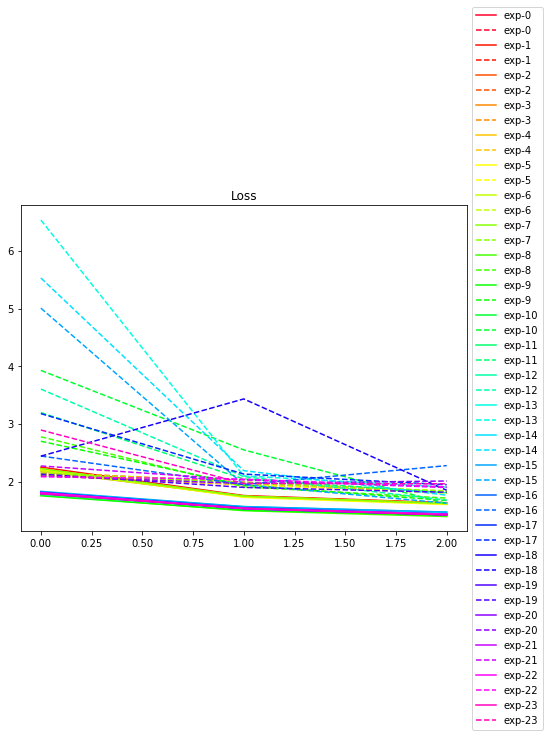

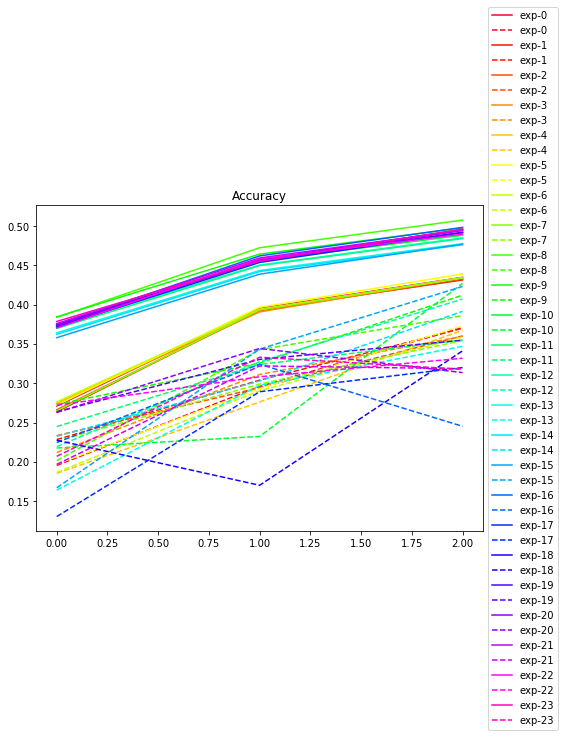

In [112]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()